### This notebook demonstrates how to write images to TensorFlow `tfrecord` file format.

In [1]:
import cv2
import numpy as np
import tensorflow as tf

from IPython import display
import matplotlib.pyplot as plt

from utils import _bytes_feature, _int64_feature

2022-10-09 15:26:20.702460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 15:26:21.235528: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/debonair/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-09 15:26:21.235584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-09 15:26:21.337688: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alre

In [2]:
sample_video = '../inputs/video.mp4'

#Read a sample video frame with opencv.
cap = cv2.VideoCapture(sample_video)

i = 0
while True:
    ret, frame = cap.read()
    
    #Convert image to rgb.
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    if not ret:
        print('No video frames found.')
        break
    i += 1
    
    if i == 100: #Get the 100th frame.
        break

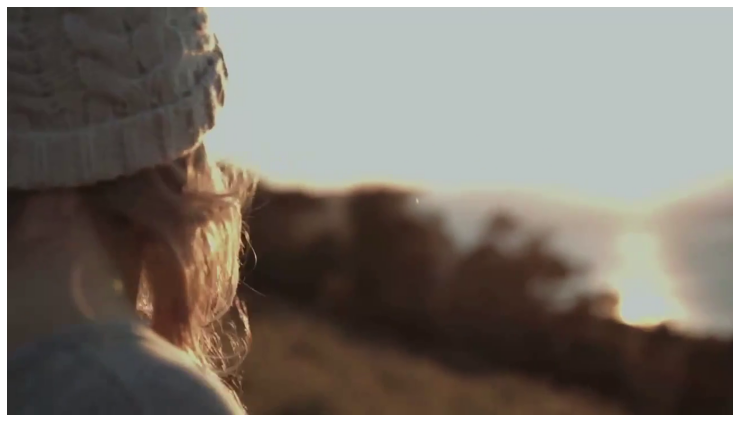

In [3]:
plt.figure(figsize = (13, 8))

plt.imshow(frame)
plt.axis('off')
plt.savefig('../inputs/sample_video_frame.jpg')
plt.show()

In [4]:
#Create a dictionary with relevant features.
def image_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape
    
    feature = {
    'height' : _int64_feature(image_shape[0]),
    'width': _int64_feature(image_shape[1]),
    'depth': _int64_feature(image_shape[2]),
    'label': _bytes_feature(label),
    'image_raw': _bytes_feature(image_string)
    }
    
    return tf.train.Example(features = tf.train.Features(feature = feature))

In [5]:
image_string = open('../inputs/sample_video_frame.jpg', 'rb').read()

label = b'lady'

for line in str(image_example(image_string, label)).split('\n')[:16]:
    print(line)
    
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 576
      }
    }
...


2022-10-09 15:26:36.769490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/debonair/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-09 15:26:36.769602: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 15:26:36.769744: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debonair): /proc/driver/nvidia/version does not exist
2022-10-09 15:26:36.770896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Write image to tfrecord format.

In [6]:
record_file = '../inputs/sample_video_frame.tfrecord'

with tf.io.TFRecordWriter(record_file) as writer:
    image_string = open('../inputs/sample_video_frame.jpg', 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [7]:
!du -sh {record_file}

24K	../inputs/sample_video_frame.tfrecord


## Read the tfrecord file.
***

### The format for serializing our image to tfrecord was:
```python
    image_shape = tf.io.decode_jpeg(image_string).shape
    
    feature = {
    'height' : _int64_feature(image_shape[0]),
    'width': _int64_feature(image_shape[1]),
    'depth': _int64_feature(image_shape[2]),
    'label': _bytes_feature(label),
    'image_raw': _bytes_feature(image_string)
    }
```

In [8]:
raw_image = tf.data.TFRecordDataset('../inputs/sample_video_frame.tfrecord')

#Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string)
    }

In [9]:
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [10]:
parsed_image = raw_image.map(_parse_image_function)

In [11]:
parsed_image

<MapDataset element_spec={'depth': TensorSpec(shape=(), dtype=tf.int64, name=None), 'height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image_raw': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.string, name=None), 'width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

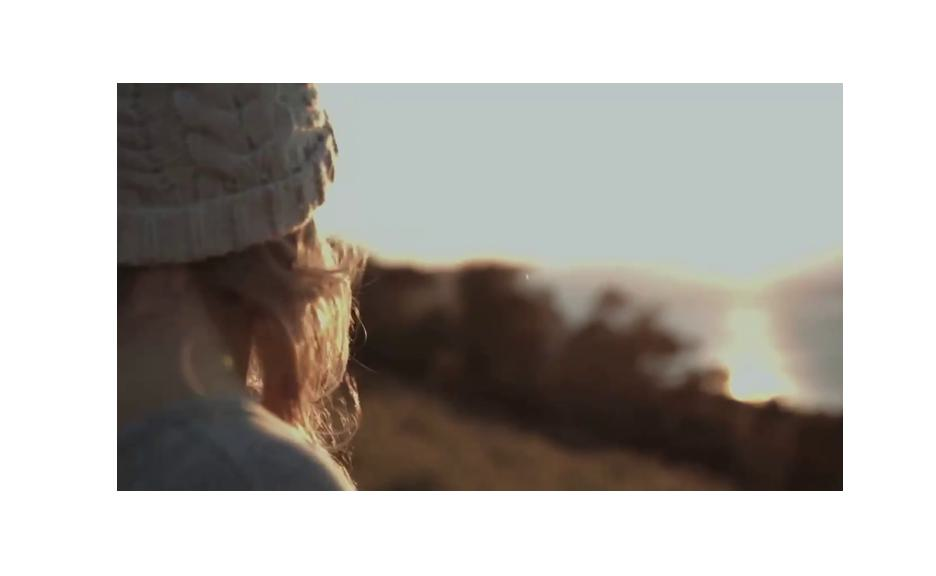

In [12]:
#Recover the image from the tfrecord file.
for image_features in parsed_image:
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data = image_raw))